<img src="https://github.com/s-simin/Data_Science_Projects/blob/main/01_Capstone_Project/images/proj_logo.png?raw=true" style="float: left; margin: 10px; height: 155px">  

<h1 style="font-family: Segoe UI; color: #3366cc; line-height: 1.3;"><strong>Capstone Project</strong><br>
Detecting Microsatellite Instability (MSI) in Colorectal Cancer Tissues</h1>

<div style="text-align: right;">
<h3>Author : Suen Si Min<br>
Course : DSI-SG-42</h3></div>

---

**Problem Statement:** <br>
How might we develop a deep learning model that accurately classifies colorectal cancer tissues as microsatellite stable (MSS) or microsatellite instable (MSI) based on histopathological image data, 
to screen patient suitability for immunotherapy treatment?

**Target Audience:** <br>
Singhealth Administrative representatives (non-medical departments)

**Summary:** <br>
- Defects in a DNA repair pathway called mismatch repair (MMR), can lead to cancer. One such cancer is colorectal cancer (CRC), which will be the focus for this data science project. One of the tests for detection of mismatch repair deficiency (dMMR) is microsatellite instability (MSI) testing. Detecting tumors with dMMR/MSI is important to determine if patients may benefit from immunotherapy. [1] For consistency, reference to dMMR will be made using MSI throughout the notebooks in this data science project.

- In this project, I aim to use Convolutional Neural Network (CNN) to detect MSI in CRC tissues by running through Hematoxylin and Eosin (H&E)-stained histology slide images.

**Data Source:** <br>
- The data sets can be found [here](https://doi.org/10.5281/zenodo.2530835) [2]
    - `CRC_DX_TRAIN_MSIMUT` - training images for colorectal cancer TCGA patients with MSI (microsatellite instable) or highly mutated tumors, 46704 unique image patches; FFPE samples.
      - Only `1630` were used for this project
    - `CRC_DX_TRAIN_MSS` - training images for colorectal cancer TCGA patients with MSS (microsatellite stable) tumors, 46704 unique image patches; FFPE samples.
      - Only `2530` were used for this project
- The journal article where these datasets were used, can be found [here](https://www.nature.com/articles/s41591-019-0462-y) [3]

<br>

**Background Information:**
- **What is Immunotherapy?**
    - Immunotherapy is a type of cancer treatment that helps your body's immune system fight cancer by using substances made from living organisms. The immune system is made up of white blood cells and organs and tissues of the lymph system. [4]
    - Only a small portion of immunotherapy patients will respond to the treatment. [4]
    - Finding ways to predict which patients will respond to treatment is a major area of research. [4]


    - <img src='../images/immunotherapy.jpg' style="float: center; margin: 0px; width: 200px; height: 150px">
    - Cancer cell (white) being attacked by two cytotoxic T cells (red), which are immune cells; part of a natural immune response [5]
    <br>
    <br>

- **Why is MSI of interest?**
    - One of the primary reasons the human body often can’t fight cancers is it doesn’t recognize cancer cells as a threat and instead sees them as normal. [6]
    - Immunotherapy increases the body’s ability to identify and attack cancer cells. Cancers that have high microsatellite instability help this effort. As the cancer cells continue to mutate, they create more proteins that the body doesn’t recognize as normal. [6]
    - It has been known that early-stage cancers with MSI had a significantly lower chance of recurrence. [6]
    - For more information about MSI, you may visit this [website](https://www.mdanderson.org/cancerwise/what-is-microsatellite-instability-MSI.h00-159617067.html).

There are a total of four notebooks for this project:  
 1. `01_Data_Cleaning_EDA.ipynb`   
 2. `02_Create_Model.ipynb`   
 3. `03_Transfer_Learning_EfficientNetV2M.ipynb`
 4. `04_Transfer_Learning_EfficientNetV2M_Tuning_Conclusion.ipynb`

---
**This Notebook**
- Data is imported and cleaned where necessary.
- Conducted Exploratory Data Analysis (EDA) & data visualisation to gather insights.

---
# **Part 1 - Data Import**

# 1. Data Dictionary

| No. | Data Type   | Description       |
|-----|-------------|-------------------|
| 1   | PNG images | - Unique image patches derived from histological images of colorectal cancer patients in the TCGA cohort (original whole slide SVS (format) images are freely available [here](https://portal.gdc.cancer.gov/)). <br>- All images were derived from formalin-fixed paraffin-embedded (FFPE) diagnostic slides ("DX" at the GDC data portal). This is explained well in this [blog](http://www.andrewjanowczyk.com/download-tcga-digital-pathology-images-ffpe/) <br><br>- **Preprocessing:** <br>- All SVS slides were preprocessed as follows: <br>&nbsp;&nbsp;&nbsp;&nbsp;- 1. automatic detection of tumor <br>&nbsp;&nbsp;&nbsp;&nbsp;- 2. resizing to 224 px x 224 px at a resolution of 0.5 µm/px <br>&nbsp;&nbsp;&nbsp;&nbsp;- 3. color normalization with the Macenko method (Macenko et al., 2009, refer [here](http://wwwx.cs.unc.edu/~mn/sites/default/files/macenko2009.pdf) <br>&nbsp;&nbsp;&nbsp;&nbsp;- 4. assignment of patients to either "MSS" (microsatellite stable) or "MSIMUT" (microsatellite instable or highly mutated) <br>&nbsp;&nbsp;&nbsp;&nbsp;- 5. randomization of patients to training and testing sets (~70% and ~30%). Randomization was done on a patient level rather than on a slide or tile level <br>&nbsp;&nbsp;&nbsp;&nbsp;- 6. equilibration of training sets by undersampling (removing excess tiles in MSS class in a random way) |

**Images** and **Data** are used interchangeably in this project, to refer to the images from this dataset.

The images are in two classes:
- MSIMUT
- MSS

**MSIMUT** and **MSI** are used interchangeably in this project, to refer to the images that are classified as microsatellite instable.

The images were further sorted into train, validation & test subfolders in the following proportions:
- Training MSIMUT:  `1000`
- Training MSS:  `1000`
- Validation MSIMUT:  `600`
- Validation MSS:  `1500`
- Testing MSIMUT:  `30`
- Testing MSS:  `30`

This distribution was chosen due to the following factors:
- Computational Constraints: Limited computational resources necessitated using a smaller subset of the full dataset.
- Balancing Representation: The validation set includes more MSS images than MSIMUT images. This reflects the higher prevalence of MSS in colorectal cancer tissues, and follows the randomization proportion (~70%, ~30%) of patients done by the author of the data source.

Important Considerations:
- It's important to acknowledge that a larger dataset would generally be preferable for optimal model training, particularly for the underrepresented MSI class.
- With more processing power, using larger datasets could prove beneficial.

# 2. Import Libraries

In [14]:
# standard imports
import pandas as pd
import numpy as np
import os
import pathlib
import datetime
from time import time

# Statistical imports
from sklearn.datasets import make_classification, make_regression # to build dummy classification, regression datasets
from sklearn.preprocessing import StandardScaler # since NN computations are linear in nature, thus scaling for standandization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Visualisation imports
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# keras imports for NN modeling
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ensure Deterministic Operations in TensorFlow
tf.config.experimental.enable_op_determinism()

# Set a random seed to reproduce the same results across all.
keras.utils.set_random_seed(42)

print('TensorFlow Version: ', tf.__version__)
print('Keras Version: ', keras.__version__)

TensorFlow Version:  2.15.0
Keras Version:  2.15.0


# 3. Set Up Variables for Pre-processing

In [15]:
# Set up global variables for pre-processing
batch_size = 64
epochs = 50
img_ht = 224
img_wdth = 224

# 4. Import Images

In [16]:
# # CODE FOR RUNNING ON GOOGLE COLAB
PATH = '/content/drive/MyDrive/Colab_Notebooks/data'

# # CODE FOR RUNNING ON LOCAL

# Assign variable for main directory
#PATH = '../data'

# Assign variables for train, validation, test directory
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

# Show file path
for i in train_dir, val_dir, test_dir:
    print(f'File paths: {i}')
print('---------------------------------')

# Assign variables for subfolders
train_msimut_dir = os.path.join(train_dir, 'MSIMUT')
train_mss_dir = os.path.join(train_dir, '1.MSS')
# Show file path
for i in train_msimut_dir, train_mss_dir:
    print(f'Subfolder paths: {i}')
print('---------------------------------')

val_msimut_dir = os.path.join(val_dir, 'MSIMUT')
val_mss_dir = os.path.join(val_dir, '1.MSS')
for i in val_msimut_dir, val_mss_dir:
    print(f'Subfolder paths: {i}')
print('---------------------------------')

test_msimut_dir = os.path.join(test_dir, 'MSIMUT')
test_mss_dir = os.path.join(test_dir, '1.MSS')
for i in test_msimut_dir, test_mss_dir:
    print(f'Subfolder paths: {i}')


File paths: /content/drive/MyDrive/Colab_Notebooks/data/train
File paths: /content/drive/MyDrive/Colab_Notebooks/data/val
File paths: /content/drive/MyDrive/Colab_Notebooks/data/test
---------------------------------
Subfolder paths: /content/drive/MyDrive/Colab_Notebooks/data/train/MSIMUT
Subfolder paths: /content/drive/MyDrive/Colab_Notebooks/data/train/1.MSS
---------------------------------
Subfolder paths: /content/drive/MyDrive/Colab_Notebooks/data/val/MSIMUT
Subfolder paths: /content/drive/MyDrive/Colab_Notebooks/data/val/1.MSS
---------------------------------
Subfolder paths: /content/drive/MyDrive/Colab_Notebooks/data/test/MSIMUT
Subfolder paths: /content/drive/MyDrive/Colab_Notebooks/data/test/1.MSS


In [17]:
# Check how many images are in each directory

# Assign variables for train, validation, test directory
num_msimut_train, num_mss_train = len(os.listdir(train_msimut_dir)), len(os.listdir(train_mss_dir))
num_msimut_val, num_mss_val = len(os.listdir(val_msimut_dir)), len(os.listdir(val_mss_dir))
num_msimut_test, num_mss_test = len(os.listdir(test_msimut_dir)), len(os.listdir(test_mss_dir))

# Get total number of images for each subfolder
total_train = num_msimut_train + num_mss_train
total_val = num_msimut_val + num_mss_val
total_test = num_msimut_test + num_mss_test

# Print Image Quantities
print('Total No. of Images in Each Subfolder:')
print('- Training MSIMUT: ', num_msimut_train)
print('- Training MSS: ', num_mss_train)
print('- Validation MSIMUT: ', num_msimut_val)
print('- Validation MSS: ', num_mss_val)
print('- Testing MSIMUT: ', num_msimut_test)
print('- Testing MSS: ', num_mss_test)
print('---------------------------------')
print('Total No. of Images in Each Directory:')
print('- Total Training images: ', total_train)
print('- Total Validation images: ', total_val)
print('- Total Testing images: ', total_test)

Total No. of Images in Each Subfolder:
- Training MSIMUT:  1000
- Training MSS:  1000
- Validation MSIMUT:  600
- Validation MSS:  1500
- Testing MSIMUT:  30
- Testing MSS:  30
---------------------------------
Total No. of Images in Each Directory:
- Total Training images:  2000
- Total Validation images:  2100
- Total Testing images:  60


---
# **Part 2 - Exploratory Data Analysis & Data Visualisation**

# 1. Visualize Some Images

In [18]:
# Place the images from each subfolder into lists
train_msimut_list = [fn for fn in os.listdir(train_msimut_dir)]
train_mss_list = [fn for fn in os.listdir(train_mss_dir)]

# Randomly select 3 images from each list
random_msimut = np.random.choice(train_msimut_list, 3, replace = False)
random_mss = np.random.choice(train_mss_list, 3, replace = False)

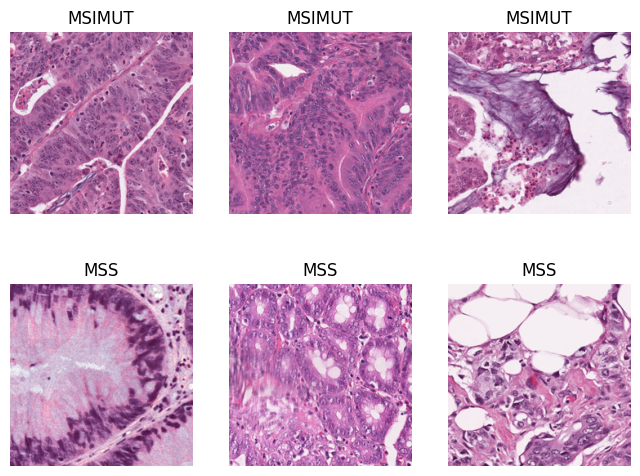

In [19]:
# Plot 2 x 3 image matrix
fig = plt.figure(figsize=(8, 6))

for i in range(6):
    if i < 3:
        image_path = os.path.join(train_msimut_dir, random_msimut[i])
        label = 'MSIMUT'
    else:
        image_path = os.path.join(train_mss_dir, random_mss[i-3])  # Adjust index for MSS images
        label = 'MSS'
    ax = fig.add_subplot(2, 3, i + 1)

    subplot = image.load_img(image_path, target_size=(224, 224), color_mode='rgb') # To plot without rescaling, remove target_size
    plt.imshow(subplot)
    plt.title(label)
    plt.axis('off')

# View images
plt.show()

# 2. Convert Images to Matrix
- For the following few steps, the pixel values of each image will be used to further analyse the images.
- This can be done by converting the images into a Numpy array using a function to iterate through each image file and turn it into a `(n, m)` matrix, where `n` is the number of observations and `m` is the number of pixels.

In [20]:
# Create function to iterate through each image and turn into n X m matrix
def img2np(path, list_of_filenames, size = (img_ht, img_wdth)):
    # Iterate through each image file
    for file_name in list_of_filenames:
        file_path = path + file_name
        current_image = image.load_img(file_path, # Load image
                                       target_size = (img_ht, img_wdth),
                                       color_mode = 'rgb'
                                       )
        # Convert image to NumPy array (matrix)
        img_ts = image.img_to_array(current_image)
        # Turn each image array into a flattened 1D array
        img_ts = [img_ts.ravel()]
        try:
            # Concatenate all images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError:
            # If full_mat has not been assigned (i.e., it's the first image being processed), it assigns full_mat to be the current image array
            full_mat = img_ts
    return full_mat # Return concatenated/single image array which contains all the images processed in the for-loop.

# Run function on training subfolders
train_msimut_images = img2np(f'{train_msimut_dir}/', train_msimut_list)
train_mss_images = img2np(f'{train_mss_dir}/', train_mss_list)

In [21]:
# Display Resultant Matrix
print(f'Matrix of Training MSIMUT Images:')
print(f'{train_msimut_images}')
print()
print(f'Matrix of Training MSS Images:')
print(f'{train_mss_images}')

Matrix of Training MSIMUT Images:
[[201. 122. 179. ... 199. 118. 176.]
 [228. 184. 214. ... 206. 129. 183.]
 [245. 231. 241. ... 238. 191. 220.]
 ...
 [240. 202. 221. ... 200. 129. 172.]
 [247. 221. 237. ... 236. 180. 213.]
 [179. 120. 167. ... 149. 116. 163.]]

Matrix of Training MSS Images:
[[189. 107. 161. ... 232. 205. 225.]
 [144.  81. 135. ... 139.  78. 135.]
 [199. 121. 177. ... 183. 109. 170.]
 ...
 [243. 239. 243. ... 140.  89. 145.]
 [204. 170. 208. ... 142.  94. 154.]
 [169. 122. 177. ... 195. 157. 198.]]


In [22]:
# Check shape of Resultant Matrix
print(f'Matrix Shape of Training MSIMUT Images: {train_msimut_images.shape}')
print(f'Matrix Shape of Training MSS Images: {train_mss_images.shape}')

Matrix Shape of Training MSIMUT Images: (1000, 150528)
Matrix Shape of Training MSS Images: (1000, 150528)


In [23]:
# Find the minimum value in the entire array
min_value = np.min(train_msimut_images)
print("Minimum value of train_msimut_images:", min_value)

# Find the maximum value in the entire array
max_value = np.max(train_msimut_images)
print("Maximum value of train_msimut_images:", max_value)

# Find the minimum value in the entire array
min_value = np.min(train_mss_images)
print("Minimum value of train_mss_images:", min_value)

# Find the maximum value in the entire array
max_value = np.max(train_mss_images)
print("Maximum value of train_mss_images:", max_value)

Minimum value of train_msimut_images: 0.0
Maximum value of train_msimut_images: 255.0
Minimum value of train_mss_images: 0.0
Maximum value of train_mss_images: 255.0


**Observation**<br>
- All pixel values are within 0 - 255 and thus the images are indeed RGB images

# 3. Visualise the Distribution of Pixel Values
- To provide an indicator to the quality of the image
- To check for outliers

## 3.1 Visualise General Distribution of Pixel Values

In [24]:
# Create a DataFrame for MSIMUT images
msimut_df = pd.DataFrame({'Pixel Value': train_msimut_images.flatten(), 'Image Class': 'MSIMUT'})

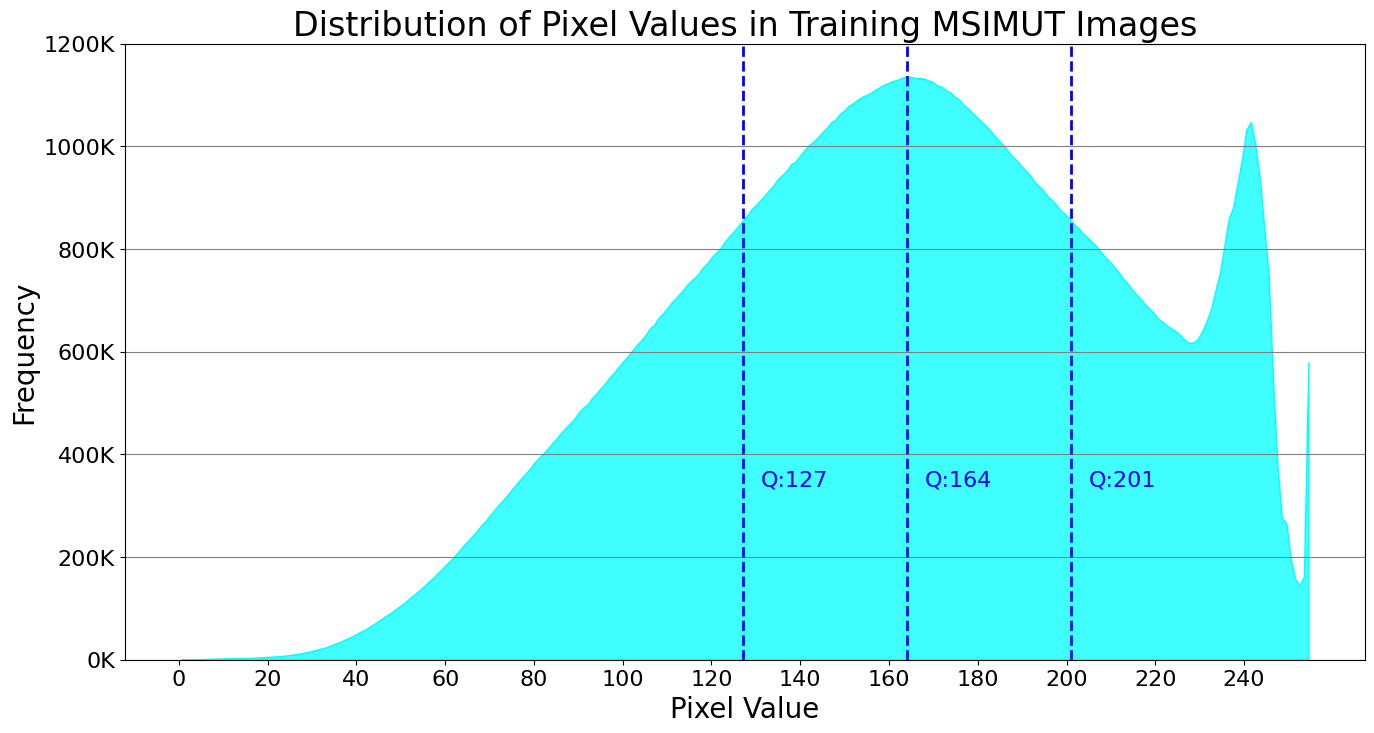

In [25]:
# Plot using distribution of pixel values for MSIMUT
plt.figure(figsize=(16, 8))
sns.histplot(data=msimut_df, x='Pixel Value', bins=256, kde=False, color='#00FFFF', element='poly')

# Set title and axis labels with different font sizes
plt.title('Distribution of Pixel Values in Training MSIMUT Images', fontsize=24)  # Adjust font size for title
plt.xlabel('Pixel Value', fontsize=20)  # Adjust font size for x-axis label
plt.ylabel('Frequency', fontsize=20)  # Adjust font size for y-axis label

# Set grid lines
plt.gca().grid(axis='y', color='grey')
plt.gca().grid(axis='x', color='none')

# Set plot background as transparent
plt.gca().set_facecolor('none')

# Get quartiles
quartiles = msimut_df['Pixel Value'].quantile([0.25, 0.5, 0.75])

# Draw quartiles on the histogram
for quartile in quartiles:
    plt.axvline(x=quartile, color='blue', linestyle='--', linewidth=2)
    plt.text(quartile + 4, 350000, f'Q:{quartile:.0f}', color='blue', ha='left', va='center', fontsize=16)

# Change y-tick labels to per 1000
plt.yticks(plt.yticks()[0], [f'{int(i / 1000)}K' for i in plt.yticks()[0]])

# Adjust x-tick and y-tick font sizes
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set x-ticks explicitly
plt.xticks(np.arange(0, 256, 20))  # Adjust the range & steps as needed

# Show the plot
plt.show()

**Observation**<br>
- The 25th percentile is at pixel value 127
- The 50th percentile, also known as the median, is at pixel value 164
- The 75th percentile is at pixel value 201

- The pixels are generally normally distributed with a slight left skew.
- An exception is where there is a spike in the pixel values around 240

In [26]:
# Create a DataFrame for MSS images
mss_df = pd.DataFrame({'Pixel Value': train_mss_images.flatten(), 'Image Class': 'MSS'})

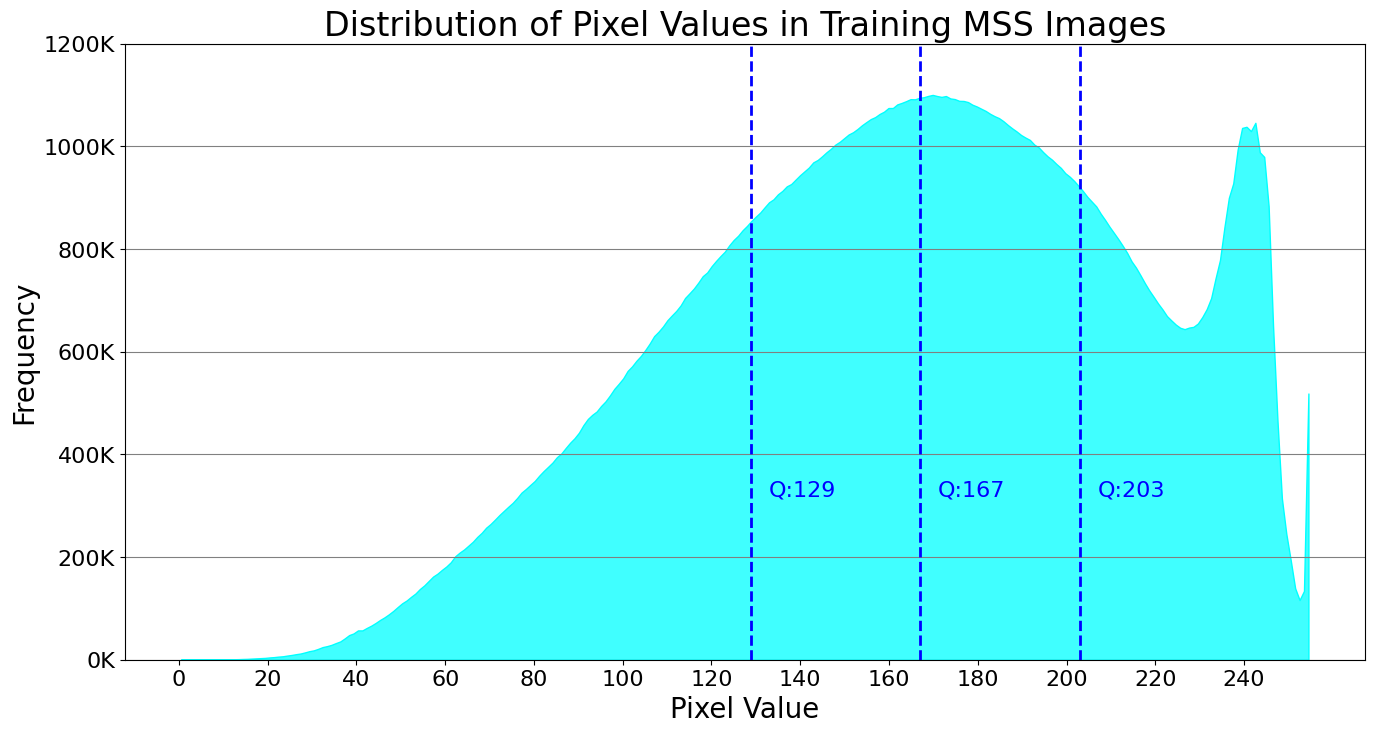

In [27]:
# Plot using distribution of pixel values for MSS
plt.figure(figsize=(16, 8))
sns.histplot(data=mss_df, x='Pixel Value', bins=256, kde=False, color='#00FFFF', element='poly')

# Set title and axis labels with different font sizes
plt.title('Distribution of Pixel Values in Training MSS Images', fontsize=24)  # Adjust font size for title
plt.xlabel('Pixel Value', fontsize=20)  # Adjust font size for x-axis label
plt.ylabel('Frequency', fontsize=20)  # Adjust font size for y-axis label

# Set grid lines
plt.gca().grid(axis='y', color='grey')
plt.gca().grid(axis='x', color='none')

# Set plot background as transparent
plt.gca().set_facecolor('none')

# Get quartiles
quartiles = mss_df['Pixel Value'].quantile([0.25, 0.5, 0.75])

# Draw quartiles on the histogram
for quartile in quartiles:
    plt.axvline(x=quartile, color='blue', linestyle='--', linewidth=2)
    plt.text(quartile + 4, 330000, f'Q:{quartile:.0f}', color='blue', ha='left', va='center', fontsize=16)

# Change y-tick labels to per 1000
plt.yticks(plt.yticks()[0], [f'{int(i / 1000)}K' for i in plt.yticks()[0]])

# Adjust x-tick and y-tick font sizes
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set x-ticks explicitly
plt.xticks(np.arange(0, 256, 20))  # Adjust the range & steps as needed

# Show the plot
plt.show()

**Observation**<br>
- The 25th percentile is at pixel value 129
- The 50th percentile, also known as the median, is at pixel value 167
- The 75th percentile is at pixel value 203

- The pixels are generally normally distributed with a slight left skew.
- An exception is where there is a spike in the pixel values nearer to 240


**Comparing both plots**<br>
- The 25th, 50th and 75th percentiles are similar in pixel values. The pixel values for MSS class is slightly higher, indicating that images of MSS are slightly brighter than that of MSIMUT.
- Both plots show that their pixels are generally normally distributed with a slight left skew.
- Both plots show a spike in the pixel values around 240.
- With such similarities between both plots, it could possibly mean that there are no significant variations in brightness of cancer tissues and this could mean that the two tissue classes do not significantly differ in their brightness (e.g. cancerous moles appear darker than non-cancerous moles).
- This could cause difficulty in detecting MSI based on brightness.

<br><br>
The next step shows the distribution per color channel for a more detailed analysis.

## 3.2 Visualise Distribution of Pixel Values per RGB color channel

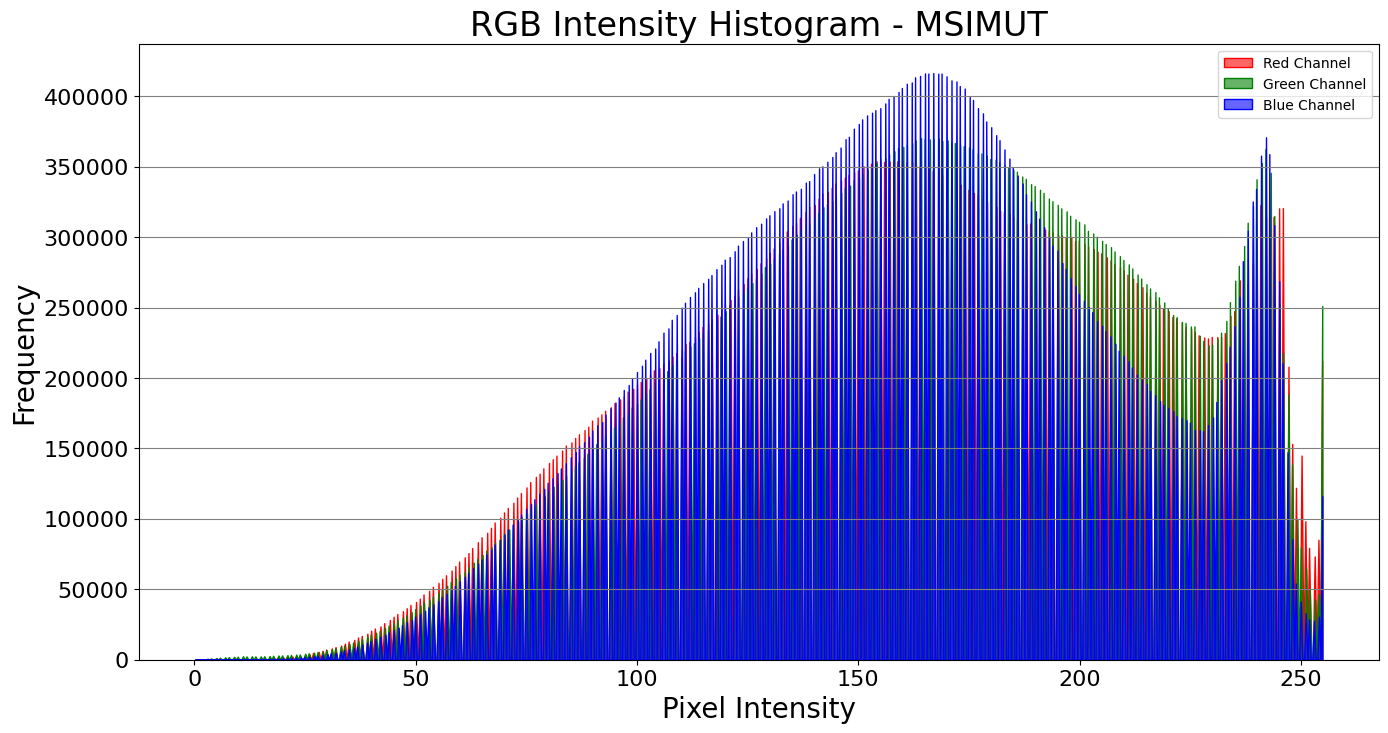

<Figure size 640x480 with 0 Axes>

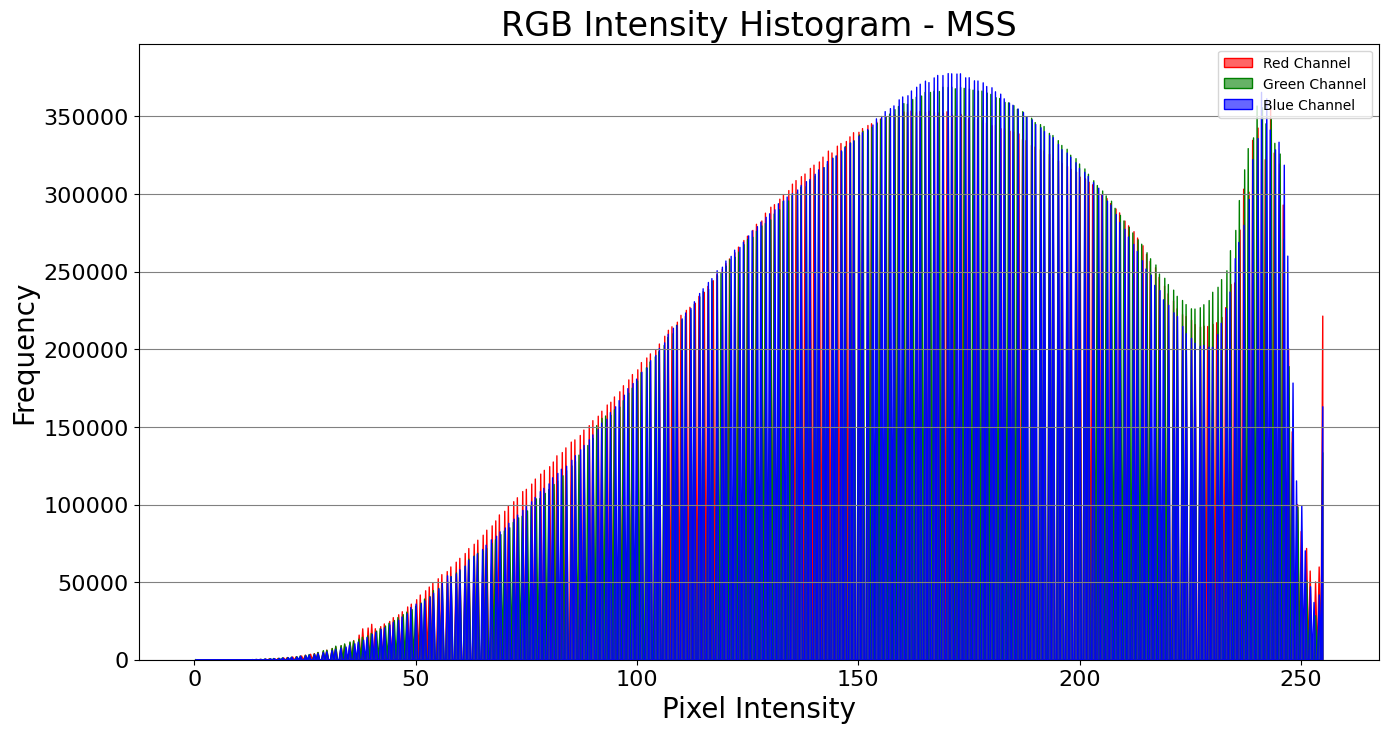

<Figure size 640x480 with 0 Axes>

In [28]:
# Create function to generate a histogram of the 3 color channels as overlaying layers
def plot_rgb_histograms(class_name, pixels_rgb):
    plt.figure(figsize=(16, 8))

    # Split RGB channels
    num_pixels = len(pixels_rgb) // 3
    red_channel = pixels_rgb[:num_pixels]
    green_channel = pixels_rgb[num_pixels:2*num_pixels]
    blue_channel = pixels_rgb[2*num_pixels:]

    # Histogram plot
    sns.histplot(red_channel, kde=False, color='red', alpha=0.6, label='Red Channel', element='poly')
    sns.histplot(green_channel, kde=False, color='green', alpha=0.6, label='Green Channel', element='poly')
    sns.histplot(blue_channel, kde=False, color='blue', alpha=0.6, label='Blue Channel', element='poly')

    # Styling
    plt.title(f'RGB Intensity Histogram - {class_name}', fontsize=24)
    plt.xlabel('Pixel Intensity', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True, axis='y', color='grey')  # Horizontal gridlines only
    plt.legend()

    # Transparent Background (may require adjustment based on your environment)
    plt.figure().patch.set_alpha(0)

    plt.show();

# View histogram for MSIMUT images
plot_rgb_histograms('MSIMUT', train_msimut_images.flatten())
# View histogram for MSS images
plot_rgb_histograms('MSS', train_mss_images.flatten())

**Observation**<br>
- General observation:
  - All 3 color channels have similar frequency of pixel values.
  - `Blue` has the highest frequency of values around the median followed by `green` and lastly `red`.

- Differences:
  - Distribution for MSS is more towards the right than for MSIMUT, indicating that values are slightly brighter for MSS images.
  - MSIMUT images have higher frequency of pixel values in the median in the `blue` channel as compared to MSS images, which may imply that MSIMUT images have a slightly more bluish tint compared to MSS images.

**Conclusion**<br>
As the differences in pixel distribution between both classes are small, it can be inferred that no obvious differences can be detected by the naked eye. Therefore, turning to deep learning models potentially allows us to uncover subtle patterns that may distinguish MSIMUT and MSS cancer tissues.

# 4. Visualise the Average Image

- Visualise what the average image looks like for each class by obtaining the average value of each pixel across all observations.

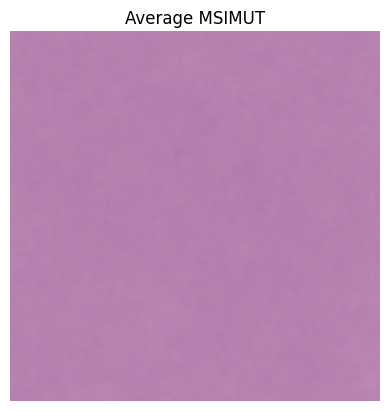

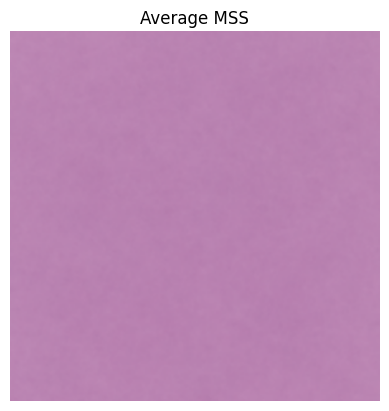

In [29]:
def find_mean_img(full_mat, title, size=(img_ht, img_wdth)):
    # Calculate the average of the images in each subfolder
    mean_img = np.mean(full_mat, axis = 0)
    # Reshape it back to a matrix
    mean_img = mean_img.reshape(size[0], size[1], 3)
    # Convert data type to unsigned 8-bit integers (uint8, ranging 0 to 255)
    mean_img = mean_img.astype('uint8')
    plt.imshow(mean_img,
               #cmap='Greys_r',     # Used to determine color map
               )
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

# Run function on matrix of training subfolders
train_msimut_mean = find_mean_img(train_msimut_images, 'MSIMUT')
train_mss_mean = find_mean_img(train_mss_images, 'MSS')

**Observation**<br>
- No clear observation can be made from the average image for each class.
- This could possibly be because the nature of these tissue slide tiles is such that the average human eye is unable to detect obvious patterns

# 5. Visualise the Contrast Between Average Images
- Using the average images, we can also compute the difference between the two classes

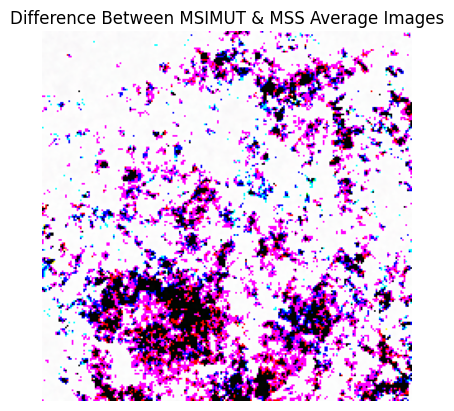

In [30]:
# Assign variable for the difference
contrast_mean = train_msimut_mean - train_mss_mean

plt.imshow(contrast_mean,
           #cmap='Greys_r',     # Used to determine color map
           )
plt.title(f'Difference Between MSIMUT & MSS Average Images')
plt.axis('off')
plt.show()

**Observation**<br>
- No clear observation can be made from the difference between the average image for each class.
- This could possibly be because the nature of these tissue slide tiles is such that the average human eye is unable to detect obvious patterns

**Conclusion**<br>
- The images do not appear to have apparent features that distinguish between both classes.
- The application of deep learning techniques will be necessary to explore and identify any subtle patterns for classification, which will be carried out next.

---
# **Part 3 - Data Pre-Processing**

# 1. Pre-Processing Images to Prepare for Modelling

In [31]:
# Instantiate ImageDataGenerator object from Keras & Execute Data Augmentation for training data
train_image_generator = ImageDataGenerator(rescale = 1./255,    # Rescaling image: set rescale parameter equal to 1/255 to normalize these values
                                           rotation_range = 45,
                                           width_shift_range = 0.20,
                                           height_shift_range = 0.20,
                                           shear_range=0.20,
                                           horizontal_flip = True,
                                           zoom_range = 0.5
                                           )

# Generate batches of images and their corresponding class labels from a directory
train_data_gen = train_image_generator.flow_from_directory(batch_size = batch_size,
                                                           directory = train_dir,
                                                           shuffle = True,
                                                           target_size = (img_ht, img_wdth),    # Resizing image
                                                           class_mode = 'binary',
                                                           seed = 42,
                                                        #    save_to_dir ='../data/augmentedimages', # Store augmented images in a folder to check if they are correctly generated
                                                        #    save_prefix = 'expt_rmk',
                                                        #    save_format ='png'
                                                           )

# Instantiate ImageDataGenerator without Data Augmentation for validation data
val_image_generator = ImageDataGenerator(rescale = 1./255) # only scaling parameter is required for validation data

# Generate batches of images and their corresponding class labels from a directory
val_data_gen = val_image_generator.flow_from_directory(batch_size = batch_size,
                                                       directory = val_dir,
                                                       target_size = (img_ht, img_wdth),
                                                       class_mode = 'binary',
                                                       seed = 42
                                                       )

Found 2000 images belonging to 2 classes.
Found 2100 images belonging to 2 classes.


In [32]:
# Check the classes that ImageDataGenerator was able to find using .class_indices
class_mappings = train_data_gen.class_indices # save output mappings dictionary to 'class_mappings' variable to use later for predictions
print(class_mappings)

{'1.MSS': 0, 'MSIMUT': 1}


**Explanation**<br>
The `MSS` class was labelled as `1.MSS` in the subfolders because standardisation for MSS as class 0, indicating the absence of MSI, would be more intuitive.

# 2. Display Augmented Images

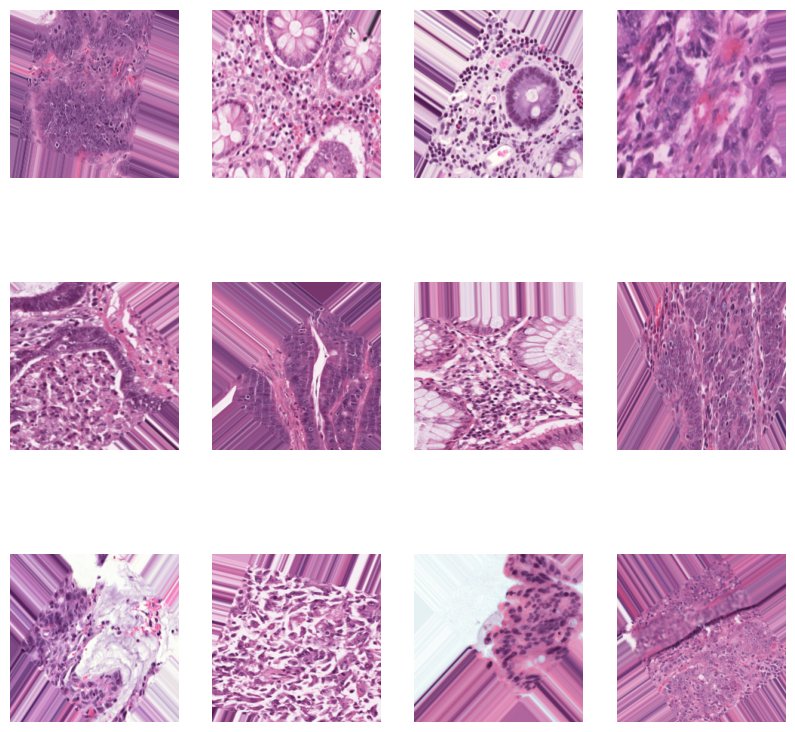

In [33]:
# Generate a batch of augmented images
augmented_images, _ = next(train_data_gen)

# Display the first 12 augmented images
plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis("off")
plt.show()


---
# **Part 4 - References**

# 1. Citations

[1] Hildebrand LA, Pierce CJ, Dennis M, Paracha M, Maoz A. Artificial Intelligence for Histology-Based Detection of Microsatellite Instability and Prediction of Response to Immunotherapy in Colorectal Cancer. Cancers. 2021; 13(3):391. https://doi.org/10.3390/cancers13030391

[2] Kather, J. N. (2019). Histological images for MSI vs. MSS classification in gastrointestinal cancer, FFPE samples [Data set]. Zenodo. https://doi.org/10.5281/zenodo.2530835

[3] Kather, J.N., Pearson, A.T., Halama, N. et al. Deep learning can predict microsatellite instability directly from histology in gastrointestinal cancer. Nat Med 25, 1054–1056 (2019). https://doi.org/10.1038/s41591-019-0462-y

[4] ['Immunotherapy to Treat Cancer', National Cancer Institute](https://www.cancer.gov/about-cancer/treatment/types/immunotherapy)

[5] [Image created by Rita Elena Serda; Source: National Cancer Institute](https://visualsonline.cancer.gov/details.cfm?imageid=10486)

[6] ['What is microsatellite instability?', MD Anderson Cancer Center](https://www.mdanderson.org/cancerwise/what-is-microsatellite-instability-MSI.h00-159617067.html)